# NFL Big Data Bowl 2024


## Attempting to predict direction and pass/run of the play based on pre-snap information.


## Importing dataview libraries


In [497]:
import re

import pandas as pd
import numpy as np

from xgboost import XGBClassifier

import nfl_data_py as nfl


In [498]:
DATA_ROOT = '../data/'

In [536]:
raw = nfl.import_pbp_data(range(2022, 2024))
all_cols = nfl.see_pbp_cols()

2022 done.
2023 done.
Downcasting floats.


In [537]:
for col in all_cols:
    print(col)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [538]:
raw.posteam.value_counts()

posteam
PHI    2562
NYG    2494
KC     2476
MIN    2469
DAL    2447
CIN    2417
WAS    2417
TB     2409
LAC    2406
JAX    2397
BUF    2375
SF     2370
ARI    2368
CLE    2354
BAL    2344
IND    2284
SEA    2274
DET    2268
MIA    2230
LV     2219
DEN    2217
CHI    2213
PIT    2212
NO     2208
NYJ    2189
ATL    2178
HOU    2177
CAR    2164
GB     2156
NE     2127
LA     2125
TEN    2090
Name: count, dtype: int64

In [580]:
df = raw.copy()

In [581]:
cols = ['yardline_100', 'down', 'ydstogo', 'goal_to_go', 'play_type', 'score_differential', 'defenders_in_box', 'posteam', 'defteam', 'offense_formation', 'defense_personnel', 'run_location', 'run_gap', 'pass_length', 'pass_location']
df = df[cols]
play_type_mask = df['play_type'].isin(['kickoff', 'no_play', 'punt', 'field_goal', 'extra_point', 'qb_kneel', 'qb_spike', None])
df = df[~play_type_mask]
df = df[df['defense_personnel'].notnull()]
df = df[df.down != 4]
# df = df[df.down != 1]

In [598]:
def make_play_string(row):
    ret_str = ''
    if row['play_type'] == 'pass':
        ret_str += 'pass-'
        if row['pass_length'] == 'short':
            ret_str += 'short-'
        elif row['pass_length'] == 'deep':
            ret_str += 'deep-'
        if row['pass_location'] == 'left':
            ret_str += 'left'
        elif row['pass_location'] == 'middle':
            ret_str += 'middle'
        elif row['pass_location'] == 'right':
            ret_str += 'right'
        if ret_str == 'pass-':
            ret_str += 'other'
    elif row['play_type'] == 'run':
        ret_str += 'run-'
        if row['run_location'] == 'left':
            ret_str += 'left-'
        elif row['run_location'] == 'middle':
            ret_str += 'middle'
            return ret_str # Short circuit for now
        elif row['run_location'] == 'right':
            ret_str += 'right-'
        else:
            return 'ERROR'
        if row['run_gap'] == 'end':
            ret_str += 'end'
        elif row['run_gap'] == 'guard':
            ret_str += 'guard'
        elif row['run_gap'] == 'tackle':
            ret_str += 'tackle'
        else:
            return 'ERROR'
    else:
        return 'ERROR'
    return ret_str

def clean_personnel_string(row):
    input_str = row['defense_personnel']
    input_str = input_str.replace(' ', '')
    input_str = input_str.replace(',', '-')
    return input_str

In [583]:
df['play_string'] = df.apply(make_play_string, axis=1)
df = df[df.play_string != 'ERROR']
df['play_string'].value_counts()

play_string
pass-short-right     10019
pass-short-left       9042
run-middle            5771
pass-short-middle     5141
run-left-end          3180
run-right-end         2909
run-right-guard       2850
run-left-guard        2806
run-left-tackle       2793
run-right-tackle      2535
pass-                 2306
pass-deep-right       2100
pass-deep-left        2043
pass-deep-middle       991
Name: count, dtype: int64

In [584]:
df['defense_personnel'] = df.apply(clean_personnel_string, axis=1)
df['defense_personnel'].value_counts()

defense_personnel
4DL-2LB-5DB    14714
2DL-4LB-5DB     9818
3DL-3LB-5DB     9486
3DL-4LB-4DB     6458
4DL-3LB-4DB     5047
               ...  
0DL-4LB-6DB        1
4DL-3LB-5DB        1
3DL-6LB-2DB        1
5DL-1LB-6DB        1
1DL-3LB-6DB        1
Name: count, Length: 64, dtype: int64

In [585]:
numerical_cols = ['yardline_100', 'ydstogo', 'score_differential', 'defenders_in_box']
categorical_cols = ['down', 'offense_formation', 'defense_personnel', 'goal_to_go', 'posteam', 'defteam']
target_col = 'play_string'
target_raw = df[target_col].copy()

In [586]:
from sklearn.preprocessing import LabelEncoder

df = df[numerical_cols + categorical_cols + [target_col]]
les = {}
for col in categorical_cols+[target_col]:
    les[col] = LabelEncoder()
    df[col] = les[col].fit_transform(df[col])
df = df.dropna()

array([[<Axes: title={'center': 'yardline_100'}>,
        <Axes: title={'center': 'ydstogo'}>,
        <Axes: title={'center': 'score_differential'}>],
       [<Axes: title={'center': 'defenders_in_box'}>,
        <Axes: title={'center': 'down'}>,
        <Axes: title={'center': 'offense_formation'}>],
       [<Axes: title={'center': 'defense_personnel'}>,
        <Axes: title={'center': 'goal_to_go'}>,
        <Axes: title={'center': 'posteam'}>],
       [<Axes: title={'center': 'defteam'}>, <Axes: >, <Axes: >]],
      dtype=object)

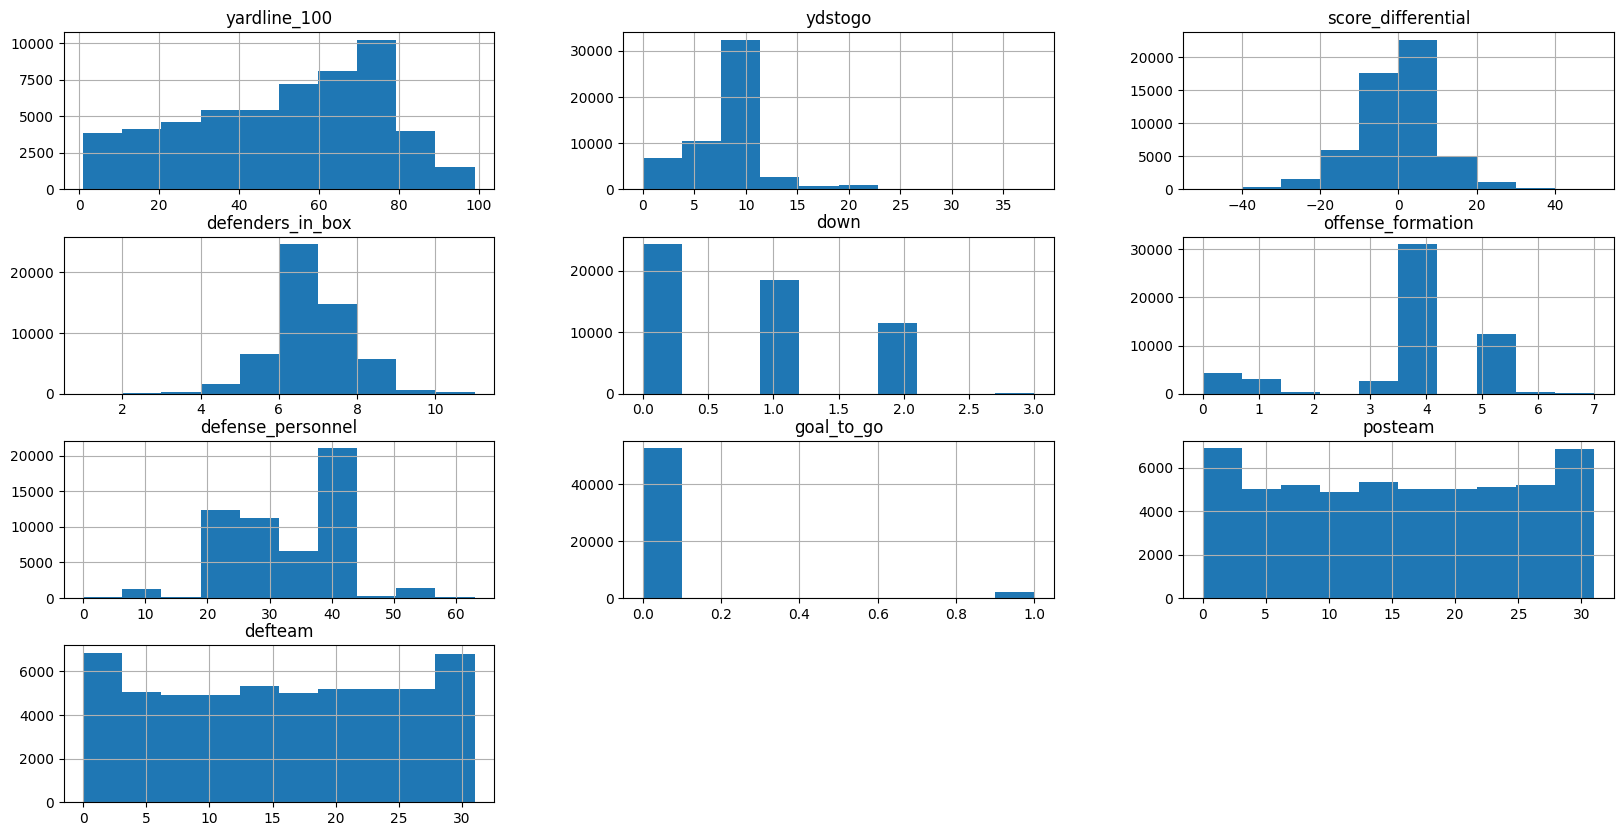

In [587]:
df.hist(column=numerical_cols+categorical_cols, figsize=(20, 10))

In [588]:
target = df.pop(target_col)

In [589]:
from sklearn.model_selection import train_test_split

X_big, X_test, y_big, y_test = train_test_split(df, target, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_big, y_big, test_size=0.2)

In [599]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

LR = 0.2

def get_class_score(n_estimators, max_depth, max_leaves, learning_rate):
    clf = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        max_leaves=max_leaves,
                        learning_rate=learning_rate,
                        n_jobs=12,
                        early_stopping_rounds=10,
                        random_state=0)
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print (f'Estimators: {n_estimators}, Depth: {max_depth}, Leaf: {max_leaves}, LR: {learning_rate}, Accuracy: {acc}')
    return acc, classification_report(y_val, preds, target_names=les[target_col].classes_, zero_division=0)

Estimators: 200, Depth: 1, Leaf: 0, LR: 0.2, Accuracy: 0.2099105299380592
Estimators: 200, Depth: 2, Leaf: 0, LR: 0.2, Accuracy: 0.21277816012846984
Estimators: 200, Depth: 3, Leaf: 0, LR: 0.2, Accuracy: 0.21289286533608626
Estimators: 200, Depth: 4, Leaf: 0, LR: 0.2, Accuracy: 0.2091075934847442
Best depth: 3


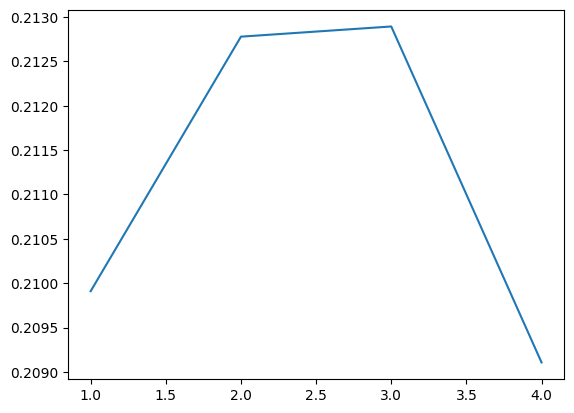

In [601]:
import matplotlib.pyplot as plt
%matplotlib inline

depth_scores = dict([(d, get_class_score(200, d, 0, LR)) for d in range(1, 5)])
plt.plot(list(depth_scores.keys()), [x[0] for x in depth_scores.values()])
temp_best_depth = max(depth_scores, key=depth_scores.get)
best_depth = temp_best_depth
print(f'Best depth: {best_depth}')


In [603]:
leaf_scores = dict([(l, get_class_score(200, best_depth, l, LR)) for l in range(8, 20)])
plt.plot(list(leaf_scores.keys()), [x[0] for x in leaf_scores.values()])
temp_best_leaf = max(leaf_scores, key=leaf_scores.get)
best_leaf = temp_best_leaf
print(f'Best leaf: {best_leaf}')

Estimators: 200, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.21289286533608626
Estimators: 200, Depth: 3, Leaf: 9, LR: 0.2, Accuracy: 0.21289286533608626
Estimators: 200, Depth: 3, Leaf: 10, LR: 0.2, Accuracy: 0.21289286533608626


KeyboardInterrupt: 

Estimators: 400, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7333257195066241
Estimators: 420, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7340109639104614
Estimators: 440, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7343535861123801
Estimators: 460, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7340109639104614
Estimators: 480, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7348104157149383
Estimators: 500, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7343535861123801
Estimators: 520, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7349246231155779
Estimators: 540, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7343535861123801
Estimators: 560, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7336683417085427
Estimators: 580, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.734125171311101
Estimators: 600, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.734125171311101
Estimators: 620, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7342393787117405
Estimators: 640, Depth: 7, Leaf: 23, LR: 0.05, Accuracy: 0.7342393787117405
Estimators: 66

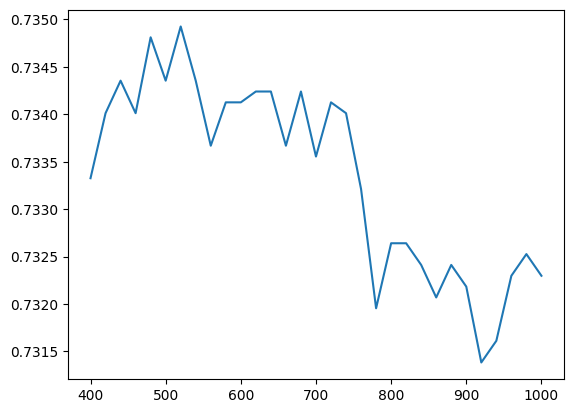

In [ ]:
est_scores = dict([(est, get_class_score(est, best_depth, best_leaf, LR)) for est in range(400, 601, 20)])
plt.plot(list(est_scores.keys()), [x[0] for x in est_scores.values()])
temp_best_est = max(est_scores, key=est_scores.get)
best_est = temp_best_est
print(f'Best est: {best_est}')

In [597]:
final_clf = XGBClassifier(n_estimators=best_est, max_depth=best_depth, max_leaves=best_leaf, learning_rate=LR, n_jobs=12)
final_clf.fit(X_big, y_big)
preds = final_clf.predict(X_test)
print(classification_report(y_test, preds, target_names=les[target_col].classes_, zero_division=0))

                   precision    recall  f1-score   support

            pass-       0.78      0.08      0.14       444
   pass-deep-left       0.00      0.00      0.00       430
 pass-deep-middle       0.00      0.00      0.00       189
  pass-deep-right       0.00      0.00      0.00       430
  pass-short-left       0.22      0.23      0.23      1866
pass-short-middle       0.28      0.01      0.02      1020
 pass-short-right       0.21      0.62      0.32      1975
     run-left-end       0.17      0.06      0.09       646
   run-left-guard       0.10      0.01      0.02       570
  run-left-tackle       0.14      0.06      0.08       552
       run-middle       0.21      0.40      0.28      1145
    run-right-end       0.11      0.03      0.04       566
  run-right-guard       0.20      0.05      0.08       549
 run-right-tackle       0.19      0.04      0.07       515

         accuracy                           0.21     10897
        macro avg       0.19      0.11      0.10     1

In [605]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(df.columns),)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(les[target_col].classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.4683 - accuracy: 0.1797 - val_loss: 2.3745 - val_accuracy: 0.1809
Epoch 2/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.3823 - accuracy: 0.1903 - val_loss: 2.3486 - val_accuracy: 0.1995
Epoch 3/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.3639 - accuracy: 0.1954 - val_loss: 2.3412 - val_accuracy: 0.2031
Epoch 4/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.3579 - accuracy: 0.1985 - val_loss: 2.3379 - val_accuracy: 0.2017
Epoch 5/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.3525 - accuracy: 0.2001 - val_loss: 2.3278 - val_accuracy: 0.2022
Epoch 6/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.3468 - accuracy: 0.1984 - val_loss: 2.3265 - val_accuracy: 0.2074
Epoch 7/100
1090/1090 [==============================] - 1s 1ms/step - loss: 2.3454 - accuracy: 0.2000 - val_loss: 2.3380 - val_ac

KeyboardInterrupt: 